In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

In [56]:
font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv',encoding='utf-8')

강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)
print(len(강서_데이터))
일별_강서_데이터= 강서_데이터.groupby('기준_날짜')['전체_건수'].sum()

# Series를 DataFrame으로 변환
일별_강서_데이터 = pd.DataFrame(일별_강서_데이터.items(), columns=['기준_날짜', '전체_건수'])


3385613


In [57]:
기상청_데이터 = pd. read_csv('../../Data/기상청/기온강수량미세먼지2.csv',encoding='utf-8')
# 강수량 0인부분 채우기
기상청_데이터.fillna(0, inplace=True)
기상청_데이터.rename(columns={'일시': '기준_날짜'}, inplace=True)
기상청_데이터

,기준_날짜,미세먼지,초미세먼지,지점,지점명,평균기온(°C),일강수량(mm)
0,2023-04-01,111,56,108,서울,17.5,0.0
1,2023-04-02,60,32,108,서울,18.8,0.0
2,2023-04-03,58,32,108,서울,19.0,0.0
3,2023-04-04,38,18,108,서울,17.6,6.9
4,2023-04-05,20,10,108,서울,11.9,50.3
...,...,...,...,...,...,...,...
392,2024-03-27,24,15,108,서울,10.4,0.0
393,2024-03-28,25,11,108,서울,10.3,1.9
394,2024-03-29,277,43,108,서울,7.6,1.4
395,2024-03-30,104,23,108,서울,8.8,0.0


In [60]:

# 휴일 데이터
휴일 = [
    {"날짜": "2023-05-05"},
    {"날짜": "2023-05-29"},
    {"날짜": "2023-06-06"},
    {"날짜": "2023-08-15"},
    {"날짜": "2023-09-28"},
    {"날짜": "2023-09-29"},
    {"날짜": "2023-10-02"},
    {"날짜": "2023-10-03"},
    {"날짜": "2023-10-09"},
    {"날짜": "2023-12-25"},
    {"날짜": "2024-01-01"},
    {"날짜": "2024-02-09"},
    {"날짜": "2024-02-12"},
    {"날짜": "2024-03-01"},
]
# 주말과 휴일을 분류하는 함수 정의
def classify_weekend_and_holidays(df, holidays):
    # '일시' 열을 datetime 형식으로 변환
    df['기준_날짜'] = pd.to_datetime(df['기준_날짜'])
    
    # 주말(토요일: 5, 일요일: 6)인지 여부를 나타내는 열 추가
    df['요일'] = df['기준_날짜'].dt.dayofweek  # 0: 월요일, 1: 화요일, ..., 6: 일요일
    df['주말'] = df['요일'].apply(lambda x: 1 if x >= 5 else 0)  # 토요일(5) 또는 일요일(6)이면 주말로 분류
    
    # 휴일인지 여부를 나타내는 열 추가
    df['휴일'] = df['기준_날짜'].apply(lambda x: 1 if str(x.date()) in [h['날짜'] for h in holidays] else 0)
    
    # 주말과 휴일으로 데이터 분리
    주말_df = df[(df['주말'] == 1) | (df['휴일'] == 1)]
    주중_df = df[(df['주말'] == 0) & (df['휴일'] == 0)]
    
    return 주말_df, 주중_df

# 함수 호출
일별_휴일_데이터, 일별_강서_데이터 = classify_weekend_and_holidays(일별_강서_데이터, 휴일)

기상청_주말_데이터, 기상청_주중_데이터 = classify_weekend_and_holidays(기상청_데이터, 휴일)



In [61]:
일별_강서_데이터

,기준_날짜,전체_건수,요일,주말,휴일
0,2023-04-03,16354,0,0,0
1,2023-04-04,13309,1,0,0
2,2023-04-05,2191,2,0,0
3,2023-04-06,7303,3,0,0
4,2023-04-07,14320,4,0,0
...,...,...,...,...,...
236,2024-03-25,6757,0,0,0
237,2024-03-26,9299,1,0,0
238,2024-03-27,15206,2,0,0
239,2024-03-28,9280,3,0,0


In [62]:
# 기상청_주중_데이터의 '기준_날짜' 열을 datetime 형식으로 변환
기상청_주중_데이터['기준_날짜'] = pd.to_datetime(기상청_주중_데이터['기준_날짜'])

# 일별_강서_데이터의 '기준_날짜' 열을 datetime 형식으로 변환
일별_강서_데이터['기준_날짜'] = pd.to_datetime(일별_강서_데이터['기준_날짜'])

# 두 데이터프레임의 '기준_날짜' 값을 비교하여 있는 값과 없는 값을 구분
공통_날짜 = pd.merge(기상청_주중_데이터, 일별_강서_데이터, on='기준_날짜', how='inner')['기준_날짜']
기상청_누락_날짜 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(공통_날짜)]['기준_날짜']
강서_누락_날짜 = 일별_강서_데이터[~일별_강서_데이터['기준_날짜'].isin(공통_날짜)]['기준_날짜']

print("기상청 데이터에만 있는 날짜:")
print(기상청_누락_날짜)
기상청_주중_데이터 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(기상청_누락_날짜)]


기상청 데이터에만 있는 날짜:
307   2024-01-02
341   2024-02-05
342   2024-02-06
355   2024-02-19
356   2024-02-20
Name: 기준_날짜, dtype: datetime64[ns]


C:\Users\ciw96\AppData\Local\Temp\ipykernel_53944\3106720689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  기상청_주중_데이터['기준_날짜'] = pd.to_datetime(기상청_주중_데이터['기준_날짜'])


In [72]:
기상청_주중_데이터 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(기상청_누락_날짜)]
기상청_주중_데이터 = 기상청_주중_데이터.rename(columns={'일강수량(mm)': '강수량'})
기상청_주중_데이터.drop_duplicates(inplace=True)

In [146]:

# 기상청 데이터와 일별 데이터를 기준_날짜를 기준으로 병합
기상청_분석 = pd.merge(기상청_주중_데이터, 일별_강서_데이터, on='기준_날짜', how='inner')

기상청_분석 = 기상청_분석[['기준_날짜','강수량','전체_건수']]
기상청_분석 = 기상청_분석.loc[:,~기상청_분석.columns.duplicated()]
기상청_분석

,기준_날짜,강수량,전체_건수
0,2023-04-03,0.0,16354
1,2023-04-04,6.9,13309
2,2023-04-05,50.3,2191
3,2023-04-06,2.7,7303
4,2023-04-07,0.0,14320
...,...,...,...
236,2024-03-25,5.1,6757
237,2024-03-26,11.5,9299
238,2024-03-27,0.0,15206
239,2024-03-28,1.9,9280


In [148]:

# '기준_날짜' column을 날짜형식으로 변환
기상청_분석['기준_날짜'] = pd.to_datetime(기상청_분석['기준_날짜'])

# '기준_날짜'를 기준으로 5~10월 데이터 추출
기상청_분석_01 = 기상청_분석[(기상청_분석['기준_날짜'].dt.month >= 5) & (기상청_분석['기준_날짜'].dt.month <= 10)]

# 데이터프레임 확인
print(기상청_분석_01)

         기준_날짜  강수량  전체_건수
20  2023-05-01  0.0  14548
21  2023-05-02  0.0  18444
22  2023-05-03  0.0  19330
23  2023-05-04  0.0  18824
24  2023-05-08  0.0  18482
..         ...  ...    ...
138 2023-10-25  0.0  21856
139 2023-10-26  0.0  19820
140 2023-10-27  0.0  21286
141 2023-10-30  0.0  20988
142 2023-10-31  0.0  21598

[123 rows x 3 columns]


In [136]:

# 상관 관계 계산
correlation = 기상청_분석_01['강수량'].corr(기상청_분석_01['전체_건수'])

print("5~10월 강수량과 전체_건수 간의 상관 관계:", correlation)


5~10월 강수량과 전체_건수 간의 상관 관계: -0.8377191903020267


In [137]:
# 독립 변수(X)와 종속 변수(Y) 선택
X = 기상청_분석_01['강수량']
Y = 기상청_분석_01['전체_건수']

# 상수항 추가
X = sm.add_constant(X)

# 회귀 모델 생성 및 피팅
model = sm.OLS(Y, X).fit()

# 회귀 분석 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  전체_건수   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     284.7
Date:                Mon, 06 May 2024   Prob (F-statistic):           1.40e-33
Time:                        21:05:52   Log-Likelihood:                -1146.1
No. Observations:                 123   AIC:                             2296.
Df Residuals:                     121   BIC:                             2302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.961e+04    263.775     74.337      0.0

                               SARIMAX Results                                
Dep. Variable:                  전체_건수   No. Observations:                  123
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1215.049
Date:                Mon, 06 May 2024   AIC                           2442.099
Time:                        21:06:00   BIC                           2458.923
Sample:                             0   HQIC                          2448.932
                                - 123                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5990      0.088     -6.827      0.000      -0.771      -0.427
ar.L2         -0.5929      0.098     -6.025      0.000      -0.786      -0.400
ar.L3         -0.2571      0.113     -2.277      0.0

C:\Users\ciw96\AppData\Local\Temp\ipykernel_53944\3459193199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  기상청_분석_01['기준_날짜'] = pd.to_datetime(기상청_분석_01['기준_날짜'])
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  se

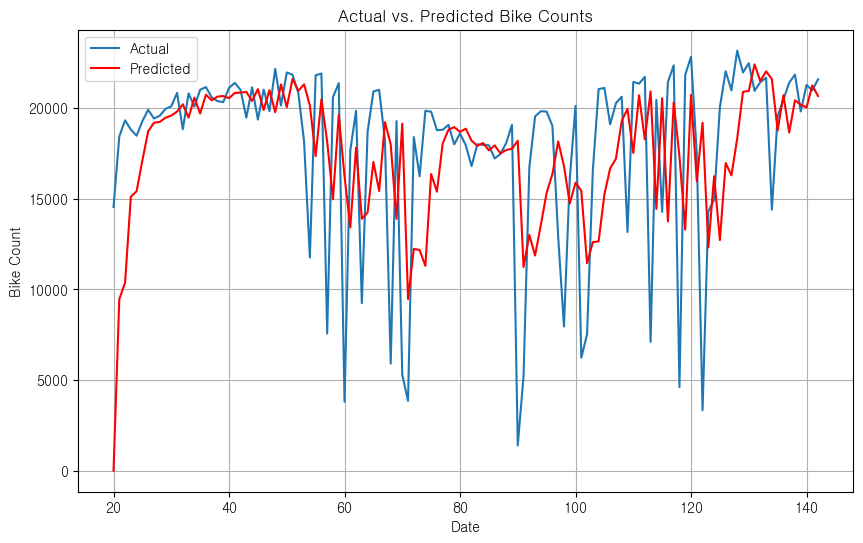

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# 데이터 전처리
기상청_분석_01['기준_날짜'] = pd.to_datetime(기상청_분석_01['기준_날짜'])

# ARIMA 모델을 학습하기 위한 시계열 데이터 준비
시계열_데이터 = 기상청_분석_01['전체_건수']

# ARIMA 모델 학습
model = ARIMA(시계열_데이터, order=(5,1,0)) # ARIMA 모델 생성
model_fit = model.fit() # 모델 학습

# 예측 결과 출력
print(model_fit.summary())

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(시계열_데이터.index, 시계열_데이터.values, label='Actual')
plt.plot(시계열_데이터.index, model_fit.predict(start=0, end=len(시계열_데이터)-1), label='Predicted', color='red')
plt.title('Actual vs. Predicted Bike Counts')
plt.xlabel('Date')
plt.ylabel('Bike Count')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
기상청_분석_01

,강수량,전체_건수
기준_날짜,,
2023-05-01,0.0,14548
2023-05-02,0.0,18444
2023-05-03,0.0,19330
2023-05-04,0.0,18824
2023-05-08,0.0,18482
...,...,...
2023-10-25,0.0,21856
2023-10-26,0.0,19820
2023-10-27,0.0,21286


C:\Users\ciw96\AppData\Local\Temp\ipykernel_53944\3529106228.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  기상청_분석_01['기준_날짜'] = pd.to_datetime(기상청_분석_01['기준_날짜'])  # 기준_날짜를 datetime 형식으로 변환


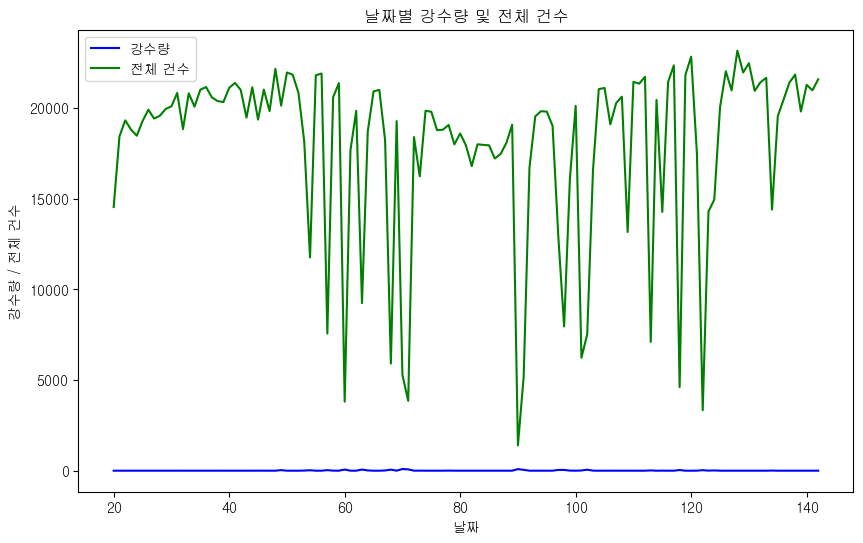

In [149]:
import pandas as pd
import matplotlib.pyplot as plt



기상청_분석_01['기준_날짜'] = pd.to_datetime(기상청_분석_01['기준_날짜'])  # 기준_날짜를 datetime 형식으로 변환


# 시각화
plt.figure(figsize=(10, 6))
plt.plot(기상청_분석_01.index, 기상청_분석_01['강수량'], label='강수량', color='blue')
plt.plot(기상청_분석_01.index, 기상청_분석_01['전체_건수'], label='전체 건수', color='green')
plt.xlabel('날짜')
plt.ylabel('강수량 / 전체 건수')
plt.title('날짜별 강수량 및 전체 건수')
plt.legend()
plt.show()

In [154]:
기상청_분석

,기준_날짜,강수량,전체_건수
0,2023-04-03,0.0,16354
1,2023-04-04,6.9,13309
2,2023-04-05,50.3,2191
3,2023-04-06,2.7,7303
4,2023-04-07,0.0,14320
...,...,...,...
236,2024-03-25,5.1,6757
237,2024-03-26,11.5,9299
238,2024-03-27,0.0,15206
239,2024-03-28,1.9,9280


In [163]:
from statsmodels.tsa.stattools import adfuller

# ADF 검정 수행 함수 정의
def adf_test(timeseries):
    # ADF 검정 수행
    result = adfuller(timeseries)
    
    # 결과 출력
    print('ADF 검정 통계량:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# 시계열 데이터에 대한 ADF 검정 수행
adf_test(기상청_분석['전체_건수'])

ADF 검정 통계량: -1.4282100852735171
p-value: 0.5686796443010156
Critical Values:
   1%: -3.459105583381277
   5%: -2.8741898504150574
   10%: -2.5735117958412097


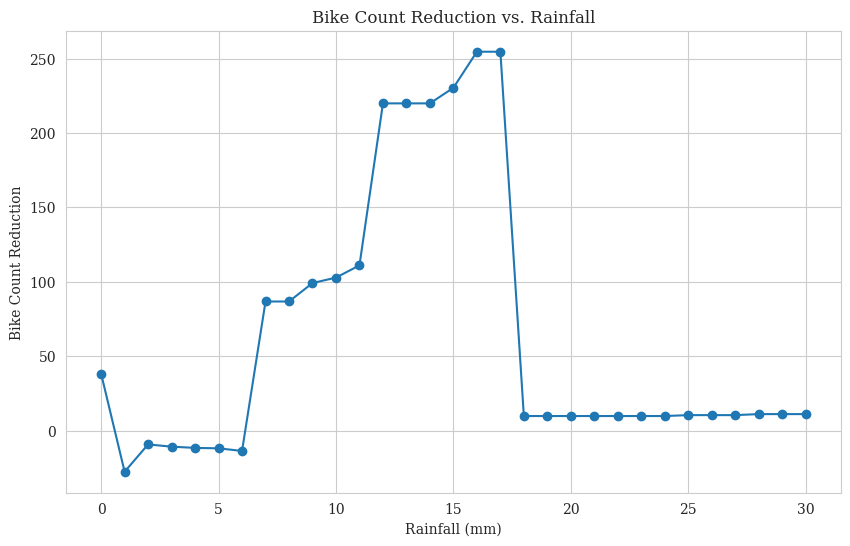

    강수량(mm)      이용량_감소
0         0   38.166069
1         1  -27.699213
2         2   -9.342712
3         3  -10.863618
4         4  -11.678390
5         5  -11.977835
6         6  -13.739282
7         7   86.716789
8         8   86.716789
9         9   99.104902
10       10  102.775454
11       11  110.997491
12       12  219.879019
13       13  219.879019
14       14  219.879019
15       15  230.349449
16       16  254.596759
17       17  254.596759
18       18    9.733587
19       19    9.733587
20       20    9.733587
21       21    9.733587
22       22    9.733587
23       23    9.733587
24       24    9.733587
25       25   10.341936
26       26   10.341936
27       27   10.341936
28       28   11.031398
29       29   11.031398
30       30   11.031398


In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모델을 학습하기 위한 시계열 데이터 준비
시계열_데이터 = 기상청_분석[['강수량', '전체_건수']]

# ARIMA 모델 학습
model = ARIMA(시계열_데이터['전체_건수'], order=(3,1,0))  # ARIMA 모델 생성
model_fit = model.fit()  # 모델 학습

# 결과를 저장할 빈 리스트 생성
결과 = []

# 0mm부터 30mm까지의 강수량 범위에 대해 반복문 실행
for 강수량 in range(31):
    # 예측 결과에서 특정 강수량 범위 내의 이용량 감소 확인
    특정_강수량_범위_이용량 = model_fit.predict(start=0, end=len(기상청_분석)-1)
    특정_강수량_범위_이용량 = 특정_강수량_범위_이용량[기상청_분석['강수량'] >= 강수량]
    이용량_감소 = 특정_강수량_범위_이용량.diff().dropna()

    # 결과를 딕셔너리 형태로 저장
    결과.append({
        '강수량(mm)': 강수량,
        '이용량_감소': 이용량_감소.mean() if len(이용량_감소) > 0 else 0
    })

# 결과를 DataFrame으로 변환
결과_df = pd.DataFrame(결과)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(결과_df['강수량(mm)'], 결과_df['이용량_감소'], marker='o', linestyle='-')
plt.title('Bike Count Reduction vs. Rainfall')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Bike Count Reduction')
plt.grid(True)
plt.show()

# 결과 출력
print(결과_df)

In [160]:
기상청_분석_01

,기준_날짜,강수량,전체_건수
20,2023-05-01,0.0,14548
21,2023-05-02,0.0,18444
22,2023-05-03,0.0,19330
23,2023-05-04,0.0,18824
24,2023-05-08,0.0,18482
...,...,...,...
138,2023-10-25,0.0,21856
139,2023-10-26,0.0,19820
140,2023-10-27,0.0,21286
141,2023-10-30,0.0,20988


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ciw96\AppData\Local\Temp\ipykernel_53944\1324120273.py:30: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\ciw96\AppData\Local\Temp\ipykernel_53944\1324120273.py:30: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\ciw96\AppData\Local\Temp\ipykernel_53944\1324120273.py:30: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from c

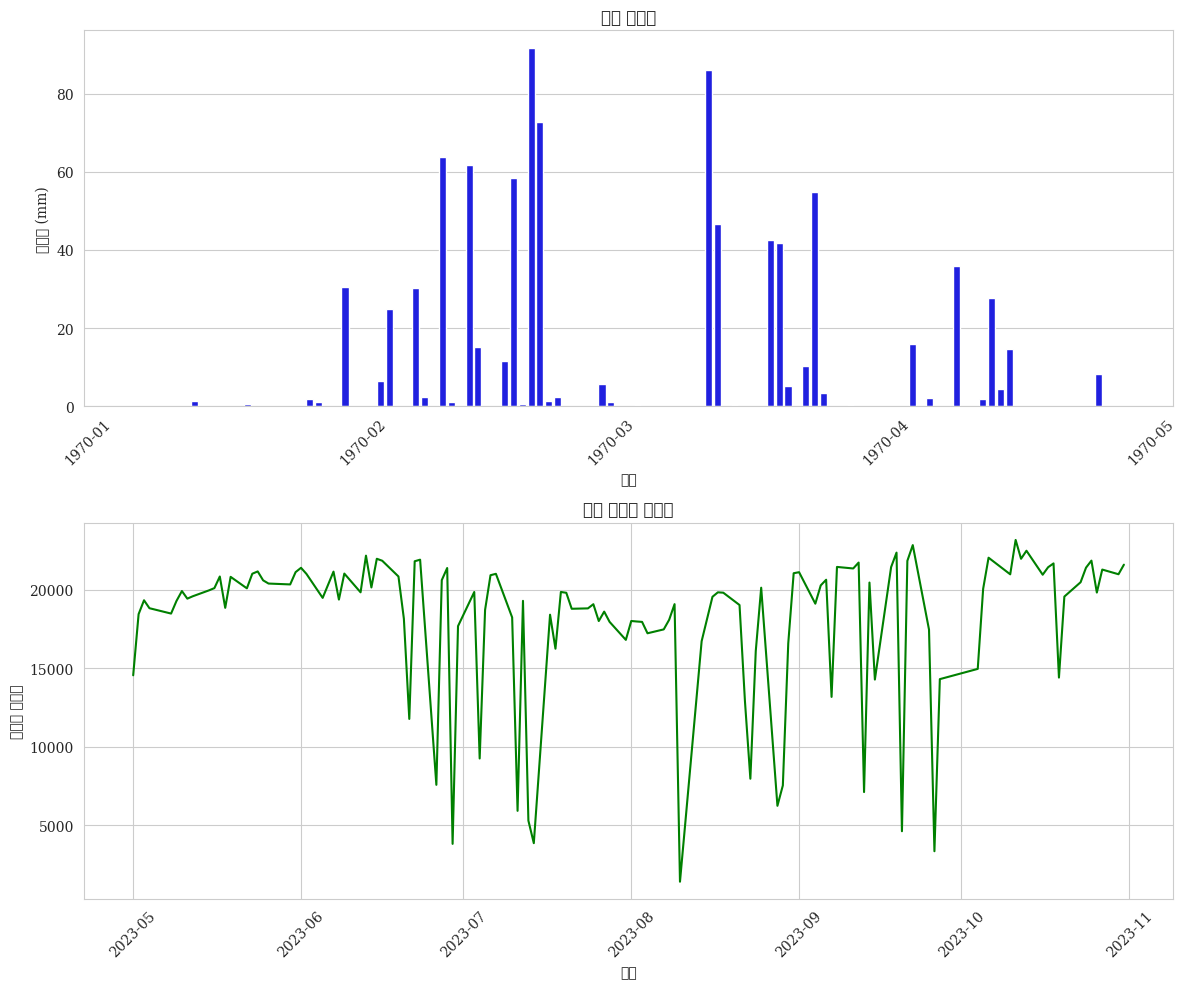

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 그래프 스타일 설정
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'serif'

# 그래프 크기 및 서브플롯 설정
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 일별 강수량 막대 그래프
sns.barplot(x='기준_날짜', y='강수량', data=기상청_분석_01, ax=axes[0], color='blue')
axes[0].set_title('일별 강수량')
axes[0].set_xlabel('날짜')
axes[0].set_ylabel('강수량 (mm)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].xaxis.set_major_locator(mdates.MonthLocator()) # 월 단위로 x 축 눈금 표시
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # 날짜 형식 지정

# 일별 이용량 선 그래프
sns.lineplot(x='기준_날짜', y='전체_건수', data=기상청_분석_01, ax=axes[1], color='green')
axes[1].set_title('일별 자전거 이용량')
axes[1].set_xlabel('날짜')
axes[1].set_ylabel('자전거 이용량')
axes[1].tick_params(axis='x', rotation=45)
axes[1].xaxis.set_major_locator(mdates.MonthLocator()) # 월 단위로 x 축 눈금 표시
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # 날짜 형식 지정

plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  전체_건수   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     284.7
Date:                Mon, 06 May 2024   Prob (F-statistic):           1.40e-33
Time:                        23:03:32   Log-Likelihood:                -1146.1
No. Observations:                 123   AIC:                             2296.
Df Residuals:                     121   BIC:                             2302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.961e+04    263.775     74.337      0.0

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda

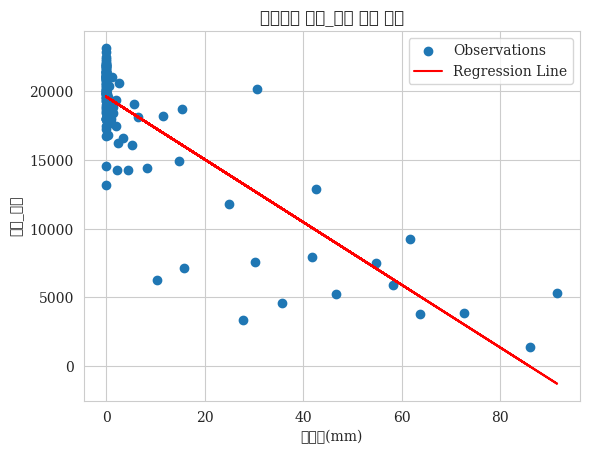

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

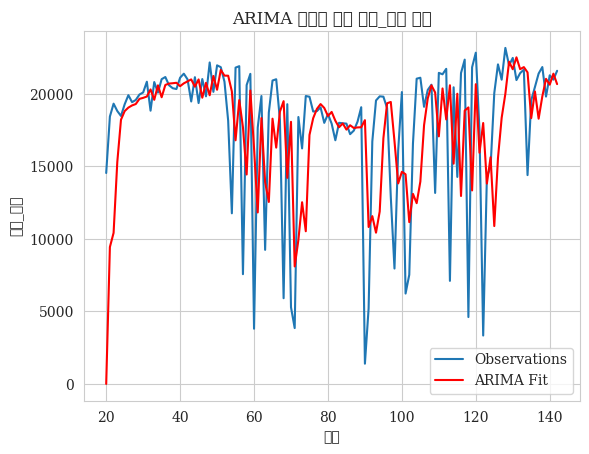

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.api import OLS, add_constant

# 강수량과 전체_건수 데이터 준비
강수량 = 기상청_분석_01['강수량']
전체_건수 = 기상청_분석_01['전체_건수']

# 회귀 분석을 위해 데이터 프레임 생성
data = pd.DataFrame({'강수량': 강수량, '전체_건수': 전체_건수})

# 회귀 모델 학습
X = data['강수량']
y = data['전체_건수']
X = add_constant(X)  # 상수항 추가
model = OLS(y, X)
result = model.fit()
print(result.summary())

# 회귀 분석 결과 시각화
plt.scatter(강수량, 전체_건수, label='Observations')
plt.plot(강수량, result.predict(X), color='red', label='Regression Line')
plt.xlabel('강수량(mm)')
plt.ylabel('전체_건수')
plt.title('강수량과 전체_건수 회귀 분석')
plt.legend()
plt.show()

# ARIMA 모델 학습
model_arima = ARIMA(전체_건수, order=(3, 1, 0))
model_arima_fit = model_arima.fit()

# ARIMA 모델 결과 시각화
plt.plot(전체_건수, label='Observations')
plt.plot(model_arima_fit.fittedvalues, color='red', label='ARIMA Fit')
plt.xlabel('날짜')
plt.ylabel('전체_건수')
plt.title('ARIMA 모델을 통한 전체_건수 예측')
plt.legend()
plt.show()

In [170]:
import numpy as np

# 예측된 전체_건수 계산
예측_전체건수 = model_fit.predict()

# 강수량의 변화량 계산
강수량_변화량 = np.diff(기상청_분석['강수량'], prepend=0)

# 예측된 전체_건수와 실제 전체_건수의 차이 계산
전체건수_차이 = 기상청_분석['전체_건수'] - 예측_전체건수

# 강수량이 갑자기 줄어드는 구간에서 전체_건수의 변화량이 큰지 확인
강수량_변화량_줄어드는_구간 = np.where(강수량_변화량 < 0)[0]
전체건수_변화량_줄어드는_구간 = 전체건수_차이[강수량_변화량_줄어드는_구간]

# 통계적 검정을 위한 분석 수행 (예시로 t-test를 사용)
from scipy import stats

# 강수량이 갑자기 줄어든 구간의 전체_건수 변화량에 대한 t-test 수행
t_statistic, p_value = stats.ttest_1samp(전체건수_변화량_줄어드는_구간, 0)

# 결과 출력
print("강수량이 갑자기 줄어드는 구간에서의 전체_건수 변화량:")
print(전체건수_변화량_줄어드는_구간)

print("\n강수량이 갑자기 줄어든 구간에서의 t-statistic:", t_statistic)
print("강수량이 갑자기 줄어든 구간에서의 p-value:", p_value)

강수량이 갑자기 줄어드는 구간에서의 전체_건수 변화량:
3      -567.376599
4      3577.584692
7      2596.612763
12     4231.777667
14     4191.150767
          ...     
228    2488.930813
233    -355.010059
236   -4793.538316
238    5190.051598
240    1612.143326
Length: 67, dtype: float64

강수량이 갑자기 줄어든 구간에서의 t-statistic: 4.403939819676564
강수량이 갑자기 줄어든 구간에서의 p-value: 3.98617035536653e-05


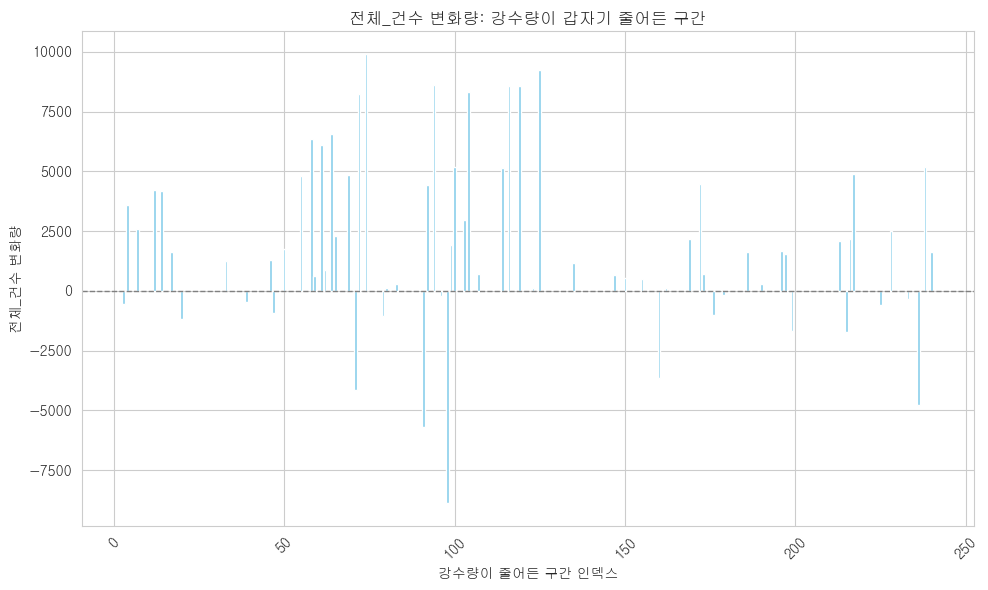

In [171]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(전체건수_변화량_줄어드는_구간.index, 전체건수_변화량_줄어드는_구간, color='skyblue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # y=0 수평선 추가
plt.title('전체_건수 변화량: 강수량이 갑자기 줄어든 구간')
plt.xlabel('강수량이 줄어든 구간 인덱스')
plt.ylabel('전체_건수 변화량')
plt.xticks(rotation=45)  # x 축 눈금 레이블 회전
plt.grid(True)
plt.tight_layout()
plt.show()